<b>Arnie Larson<br>
EEP 592 - Radar, Autumn 2022<br>
HW1</b>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy.io import wavfile


<b>1)<br></b>

A system is spec'd with it's maximum range (200 nautical miles or $370km$) and we're asked to use the radar equation to infer system parameters.<br>
Given:<br>
- f = 1300 MHz
- R = 200 nautical miles = 370.4 km
- $\sigma$ = $1m^2$
- Area = $12m$ $\times$ $4m$ $=$ $48m^2$
- $\rho_A$ = $0.65$ $\rightarrow$ $A_e$ $=$ $31.2m^2$
- $S_{min}$ $=$ $10^{-13}W$

Gain and Radar Equations:<br>
$G = \frac{4 \pi A_e}{\lambda^2}$ and $P_r = \frac{P_t G A_e \sigma}{(4 \pi)^2 R^4}$<br>
Round Trip Timing and PRF (pulse repitition frequency):<br>
$R=\frac{cT_R}{2}$;  $F_{PRF} = \frac{c}{2R_{max}}$


In [188]:
Ae = 0.65*48        # m^2
c = 3e8; f = 1300e6 # speed of light; frequency
lmbda = c/f         # radar wavelength
R = 200 * 1852      # Nautical miles to meters
G = 4*np.pi*Ae/(lmbda**2)
Pr = 1e-13          # minimum signal 10^-13 in Watts
# calculate transmit power for specs, given distance and a 1 m^2 RCS target
Pt = (R**4)*(4*np.pi)**2 * Pr/ (G*Ae*1)
PRF = c/(2*R)
Duration = 2e-6     # pulse duration
Pa = Pt * Duration * PRF  # Average output power of pulsed radar
duty_cycle= PRF * Duration * 100 # Pulse Width / Pulse repetition Time * 100%
# Assuming Horizontal beam width (3dB) can be approximated by 
# lambda / D_y in radians
beam_width = lmbda / 12 * 180 / np.pi

In [189]:
print("1) Answers")
print("Max distance R: {:n} [m]".format(R))
print("Wavelength: {:.3f} [m]".format(lmbda))
print("a) Effective Antenna Aperature: {:.3f} [m^2]".format(Ae))
print("a) Gain: {:.3f}; {:.2f} [db]".format(G, 10*np.log10(G)))
print("b) Peak Transmit Power: {:.2f} [MW]".format(Pt*1e-6))
print("c) Pulse Repetition Frequency: {:.3f} [Hz]".format(PRF))
print("d) Average transmitted power: {:.3f} [kW]".format(Pa*1e-3))
print("e) Duty Cycle: {:.3f} %".format(duty_cycle))
print("f) Horizontal beamwidth: {:.2f} deg ".format(beam_width))

1) Answers
Max distance R: 370400 [m]
Wavelength: 0.231 [m]
a) Effective Antenna Aperature: 31.200 [m^2]
a) Gain: 7362.218; 38.67 [db]
b) Peak Transmit Power: 1.29 [MW]
c) Pulse Repetition Frequency: 404.968 [Hz]
d) Average transmitted power: 1.048 [kW]
e) Duty Cycle: 0.081 %
f) Horizontal beamwidth: 1.10 deg 


<b>2 )</b><br>

Considering the moon as a radar target<br>

- $d_{Moon}$ $=$ $3.844 \times 10^8m$
- $r_{Moon}$ $=$ $1737.4km$
- $RCS = \sigma_{Moon}$ $\approx $ $6.64 \times 10^{11}m^2$

To resolve ambiguity in the return from the surface, e.g. to proble the surface, we could send pulses much more frequently.  If a single pluse takes approximately $t_{pulse} = \frac{2 \times d_{Moon}}{c}$, to resolve the surface location should take between $t_{pulse}-\frac{2 \times r_{Moon}}{c}$ and $t_{pulse}$

It is found that a peak transmit power of about 1kW is needed for this system.  This is not intuitive - but seemse sensible- though the distance is 3 orders of magnitude farther, the cross section is also 11 orders of magnitude greater than in prob 1 and the effective antenna area and gain are both large and the detection power is lower.  

The experimental moon cross section is also an order of magnitude lower than that of a perfect conductor - which is what I  expected intuitively, with negligible atmosphere and no liquid sufrace water

In [182]:
# Try to keep problem variables named different from #1
dmoon=3.844e8; sigma=6.64e11; rmoon=1.7374e6
rt = 2*dmoon/c       # round trip time to moon [s]
PRF_moon = 1/rt      # pulse repetition freqency (to resolve moon as if it's an unknown moving object)
PRF_surface = 1/(2*rmoon/c)
Ar_moon = 0.5*60*0.3048 ## antenna diameter is 60 feet -> radius in meters
# calculate effective area of this antenna and antenna gain, freq=430MHz
Pr_moon = 1.5e-16;  lmbda_moon = c/430e6; Ae_moon = .6*np.pi*Ar_moon**2 
G_moon= 4*np.pi*Ae_moon/lmbda_moon**2
Pt_moon = Pr_moon*(4*np.pi)**2*dmoon**4 / (G_moon*Ae_moon*sigma)

In [187]:
print("a) round trip time: {:.3f} [s]".format(rt))
print("b) PRF: {:.3f} [Hz]".format(PRF_moon))
print("c) Higher PRF to resolve surface distance: {:.1f} [Hz]".format(PRF_surface))
print("d) Power Transmit calculated: {:.4n} [W]".format(Pt_moon))
print("   Antenna gain G: {:n}".format(G_moon))
print("e) Ideal conductor cross section: {:.3f} x 10^12 m^2".format(np.pi*rmoon**2*1e-12))

a) round trip time: 2.563 [s]
b) PRF: 0.390 [Hz]
c) Higher PRF to resolve surface distance: 86.3 [Hz]
d) Power Transmit calculated: 1215 [W]
   Antenna gain G: 4068.91
e) Ideal conductor cross section: 9.483 x 10^12 m^2


<b>3 )</b><br>

Model the doppler signal for a low power radar module as spec'd, with a couple of moving targets, write programs to:<br>
- Plot the radar range as a function of $\sigma_{target}$
- Generate and record the IF signal output of a moving target $f_D \approx 2\nu\frac{f_{TX}}{c}$
- Generate a spectrogram of the IF signal output


Kinematics for the bicycle and car (moving away from module):<br>
$x_0=1m$; $v(t) = v_0 + a_0 t$; $x(t) = x_0 + v_0 t + \frac{1}{2}a_0 t^2$<br>
Bicycle:<br>
$v_0 = 4.5 m/s$; $a_0 = 0.1 m/s^2$<br>
Car:<br>
$v_0 = 26.8 m/s$; $a_0 = 0.5 m/s^2$<br><br>

Model the Signal:<br>
$S(t) = A( \vec{x}, \sigma) cos(\omega(\vec{v}) t + \phi)$<br>

<b>Takeaways:</b><br>
- The objects move out of the range of the radar module quickly, basically less than a second for the car and about a second for the bicycle. 
- I believe in class it was mentioned that a range of 4$m$ for a 1$m^2$ RCS was expected, so this is sensible, my signal is zero within 1 second.
- The wav file really does sound like a "ping", just an audio blip


In [12]:
# radar range as function of sigma target:
# Gain 9dBi = 8, Transmit Pt=10mW = 10e-3 W, Receiver Pr = -60dBm = 10^-6 mW  = 1e-9 W
fcw=10.5e9; Gcw=8; Prcw=1e-9; Ptcw=10e-3; lmbda_cw=c/fcw
Aecw=Gcw*lmbda_cw**2/(4*np.pi)
sigmacw=np.logspace(-2, 2)  ## log space from .01 to 100 (50 steps default)
# Radar max range for CW module:
Rcw=(Ptcw*Gcw*Aecw*sigmacw/((4*np.pi)**2 * Prcw))**(0.25)

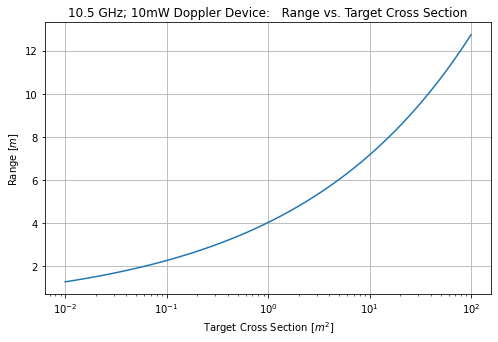

In [141]:
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(sigmacw, Rcw)
ax.set_xscale('log'); ax.grid('true')
ax.set_xlabel("Target Cross Section [$m^2$]"), ax.set_ylabel("Range [$m$]")
ax.set_title("10.5 GHz; 10mW Doppler Device:   Range vs. Target Cross Section")
plt.show()

In [22]:
# Generate radar signal, will use functions to get signal amplitude and frequency

# get signal strength (cs: cross_section, d: distance)
def get_sig(cs, d):
    sig = Ptcw*Gcw*Aecw*cs/((4*np.pi)**2*d**4)
    return sig

# max signal (cs = 100, d = 1)
Pr_max = get_sig(100, 1)+get_sig(2, 1)
print("Pr_max (car): {:.7f}".format(Pr_max))

# Function to get normalized signal amplitude, scaled to max signal
# get signal amplitude (cs: cross section, d: distance, 
#                       sig_min: signal threshold, sig_max: normalization factor)
def get_cwamp(cs, d, sig_min=Prcw, sig_max=Pr_max):
    
    sig = get_sig(cs, d)
    if sig<Prcw:
        return 0
    else:
        return 32767*sig/sig_max
    
# get signal frequency ( v: velocity, ftx: radar frequency)
def get_cwfreq(v, ftx=10.5e9):
    return 2*v*ftx/c

## Testing functions
print("Car signal at 1m: {:.3f}".format(get_cwamp(100,1)))
print("Car signal at 5m: {:.3f}".format(get_cwamp(100,5)))
print("Car signal at 10m: {:.3f}".format(get_cwamp(100,10)))
print("Car signal at 15m: {:.3f}".format(get_cwamp(100,15)))
print("Bicycle signal at 1m: {:.3f}".format(get_cwamp(2,1)))

print("IF Freq at 1m/s: {:.3f}".format(get_cwfreq(1)))
print("IF Freq at 5m/s: {:.3f}".format(get_cwfreq(5)))
print("IF Freq at 25m/s: {:.3f}".format(get_cwfreq(25)))
    
    

Pr_max (car): 0.0000269
Car signal at 1m: 32124.510
Car signal at 5m: 51.399
Car signal at 10m: 3.212
Car signal at 15m: 0.000
Bicycle signal at 1m: 642.490
IF Freq at 1m/s: 70.000
IF Freq at 5m/s: 350.000
IF Freq at 25m/s: 1750.000


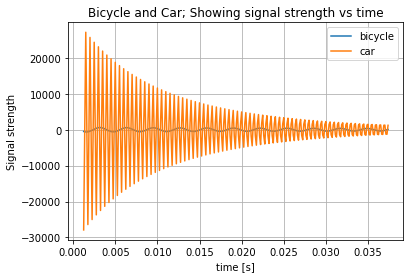

In [167]:
## Generate IF signals for moving car and bicylce
## Signal written to file: S.test.wav at 8kHz sample rate

t_max=15; f_sample=8000
t=np.linspace(0,t_max,num=f_sample*t_max)

# Signal 1 is bicycle (cs=2); Signal 2 is car (cs=100)
x0b=1; v0b=4.5; a0b=0.1
xb=x0b+v0b*t+0.5*a0b*t**2
vb=v0b+a0b*t
Ab=np.array([get_cwamp(2, x) for x in xb])
fb=np.array([get_cwfreq(v) for v in vb])
Sb=(Ab*np.cos(2*np.pi*fb*t)).astype(np.int16)

# Signal 2 is a car
x0c=1; v0c=28.6; a0c=0.5
vc=v0c+a0c*t
xc=x0c+v0c*t+0.5*a0c*t**2

# Calculate amplitude and frequency of signal vs time
Ac=np.array([get_cwamp(100, x) for x in xc])
fc=np.array([get_cwfreq(v) for v in vc])
Sc=(Ac*np.cos(2*np.pi*fc*t)).astype(np.int16)

# This is the full signal, write it to HD as a wave file
S=Sb+Sc
wavfile.write("S.test.wav", f_sample, S)

# Plot of the initial separated signals 
plt.plot(t[10:300], Sb[10:300], label='bicycle')
plt.plot(t[10:300], Sc[10:300], label='car' )
plt.xlabel("time [s]"), plt.ylabel("Signal strength")
plt.legend(loc='upper right'); plt.grid(True)
plt.title("Bicycle and Car; Showing signal strength vs time")
plt.show()

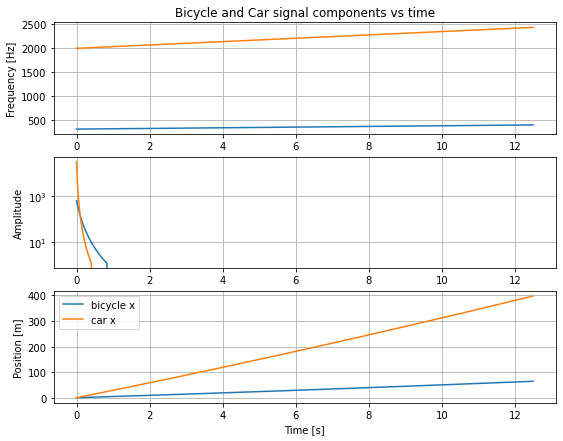

In [168]:
## Plots of the bicycle and car signals vs time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9,7));
ax1.set_title("Bicycle and Car signal components vs time")
ax1.plot(t[:100000], fb[:100000], label='bicycle fb')
ax1.plot(t[:100000], fc[:100000], label='car fc' ); ax1.grid(True)
ax2.plot(t[:100000], Ab[:100000], label='bicycle A'); ax2.set_yscale("log")
ax2.plot(t[:100000], Ac[:100000], label='car A' ); ax2.grid(True)
ax3.plot(t[:100000], xb[:100000], label='bicycle x')
ax3.plot(t[:100000], xc[:100000], label='car x' ); ax3.grid(True)
ax1.set_ylabel("Frequency [Hz]"), ax3.set_ylabel("Position [m]")
ax2.set_ylabel("Amplitude"), ax3.set_xlabel("Time [s]")

plt.legend()
plt.show()

In [169]:
## Read the data from the wavfile and plot spectrograms
rate, data = wavfile.read("S.test.wav")
# Quikcly inspet the data 
print("Rate: {:n} Hz; data[:10]: {}".format(rate, data[:10]))
# plt.plot(t[:8000], S[:8000]); plt.show()

Rate: 8000 Hz; data[:10]: [ 32766    571 -30659    617  30699    -31 -29454    226  28445   -794]


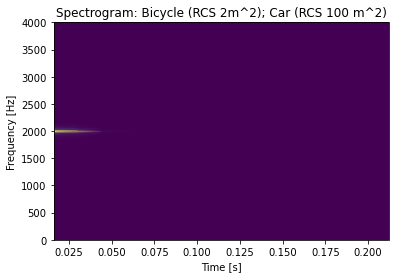

In [170]:
## 1 way to plot a spectrogram (Just first quarter second)
ftest, ttest, Sxx = signal.spectrogram(data[:2000], f_sample)
plt.pcolormesh(ttest, ftest, Sxx, shading='gouraud')
plt.xlabel("Time [s]"), plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram: Bicycle (RCS 2m^2); Car (RCS 100 m^2)")
plt.show()

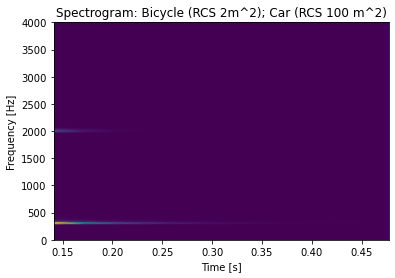

In [171]:
## Plot the spectrogram (From 1/8 of a sec to 1/2 sec)
ftest, ttest, Sxx = signal.spectrogram(data[1000:4000], f_sample)
ttest+=1/8.0
plt.pcolormesh(ttest, ftest, Sxx, shading='gouraud')
plt.xlabel("Time [s]"), plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram: Bicycle (RCS 2m^2); Car (RCS 100 m^2)")
plt.show()

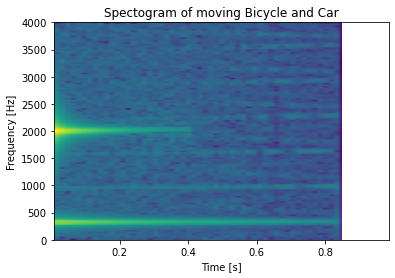

In [173]:
## Lastly - slightly better spectrogram representation, (note data is zero'd before data gets to 1s)
plt.specgram(data[:8000], Fs=8000, window=None,  scale_by_freq=False)
plt.title("Spectogram of moving Bicycle and Car"), plt.xlabel("Time [s]"), plt.ylabel("Frequency [Hz]")
plt.show()

In [137]:
# a few different testing scripts
# scipy.io.wavfile.write(filename, rate, data (1d or 2d ndarray))
# 
f_sample=8000; f_note=440; t_max=4
t=np.linspace(0,t_max,num=f_sample*t_max)
Amax = np.iinfo(np.int16).max; print("Max value is: {}".format(Amax))
A4 = .3*Amax * np.sin(2*np.pi*f_note*t)
A4 = A4.astype(np.int16)
wavfile.write("A4.test.wav", f_sample, A4)
Chirpt = .3*Amax * np.sin(2*np.pi*f_note*t + 2*np.pi*f_note*t**2)
Chirpt = Chirpt.astype(np.int16)
wavfile.write("Chirpt.test.wav", f_sample, Chirpt)

Max value is: 32767


In [138]:
print(type(A4[0]), type(Chirpt[0]))

<class 'numpy.int16'> <class 'numpy.int16'>


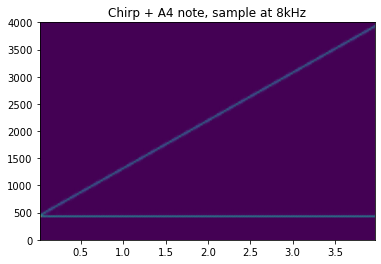

In [140]:
fa4, ta4, Sxxa4 = signal.spectrogram(A4+Chirpt, f_sample)
plt.pcolormesh(ta4, fa4, Sxxa4, shading='gouraud')
plt.title("Chirp + A4 note, sample at 8kHz")
plt.show()